### Problem Statement

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Importing libraries

In [1]:
import gc
import numpy as np #For numerical computations
import pandas as pd #For data wrangling
import matplotlib.pyplot as plt #For basic plotting
%matplotlib inline  

### Reading data

In [2]:
inputpath = "O:/"
#It is important to define the new datatypes becuase of the space each of the default ones occupy
define_dtypes = {
    'ip':'uint32',
    'app':'uint16',
    'device':'uint16',
    'os':'uint16',
    'channel':'uint16',
    'is_attributed':'uint16',
    'click_id':'uint32'
}

In [3]:
train_data = pd.read_csv(inputpath+'train.csv', nrows = 1000000,usecols = ['ip','app','device','os','channel','click_time','is_attributed'], dtype = define_dtypes)
test_data = pd.read_csv(inputpath+'test.csv',   usecols = ['ip','app','device','os','channel','click_time','click_id'], dtype = define_dtypes)

### Exploring data

In [4]:
print(train_data.isnull().sum(axis =0))
print(test_data.isnull().sum(axis =0))

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64
click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64


Interestingly, there is no missing data in train or test sets. 

In [5]:
print ('The max and the min days for which the data is collected in train dataset is %s %s' %(train_data['click_time'].min(), train_data['click_time'].max()))
print ('The max and the min days for which the data is collected in test dataset is %s %s' %(test_data['click_time'].min(), test_data['click_time'].max()))

The max and the min days for which the data is collected in train dataset is 2017-11-06 14:32:21 2017-11-06 16:21:51
The max and the min days for which the data is collected in test dataset is 2017-11-10 04:00:00 2017-11-10 15:00:00


So, we can see that the train data was collected for 2 days.We can see that the test data is collected for one day. So, looking at the train and test data we can assume that both came from the same distribution.

In [6]:
nunique = train_data.nunique(dropna = False)

In [7]:
train_data['click_day'] = pd.to_datetime(train_data['click_time']).dt.day.astype('uint8')
train_data['click_hour'] = pd.to_datetime(train_data['click_time']).dt.hour.astype('uint8')
train_data['click_minute'] = pd.to_datetime(train_data['click_time']).dt.minute.astype('uint8')
train_data = train_data.drop(['click_time'], axis = 1)

Looking for the distribution of target variable in train dataset:

0    998307
1      1693
Name: is_attributed, dtype: int64


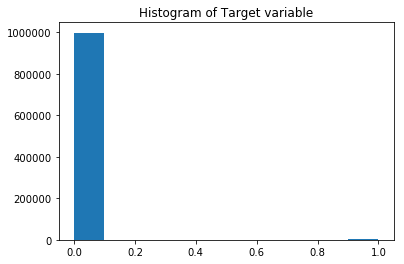

In [8]:
print(train_data['is_attributed'].value_counts())
plt.hist(train_data['is_attributed']);
plt.title("Histogram of Target variable")
plt.xlabel = "Target variable"
plt.ylabel = "Frequency percentage"
plt.show()

We can see that we are dealing with the highly imbalanced data set with 99.81% values falling under non attributed values and 0.18% falling under attributed. I would prefer to use LGBM based on the references below:
    https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code 
    Handling imbalanced datasets on : https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/    

#### Why LightGBM?

LightGBM algorithm provides special support for categorical features. We can simply use categorical_feature parameter to specify the categorical features.
It good accuracy when using native categorical features instead of one-hot coding by finding the optimal split of categorical features. Such an optimal split can provide the much better accuracy than one-hot coding solution.

In order to find the best features, the plan is to take sample data from train environment, implement lightgbm 
and then use the features that have highest gain. Currently 2 million records from the train dataset beause of the memory limitations.

Defining the function to train the lightGBM model with the given parameters:

In [9]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    #print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    model = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = model.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])
    return model 

### Feature Engineering and Modeling

In [10]:
#Importing lightgbm
import lightgbm as lgb

In [11]:
import sklearn as sk #For shuffling data
sk.utils.shuffle(train_data) #Shuffling train data to split into train and validation sets

,ip,app,device,os,channel,is_attributed,click_day,click_hour,click_minute
731570,164957,6,1,17,125,0,6,16,15
217394,14516,2,1,13,205,0,6,16,4
504431,3964,28,1,17,135,0,6,16,10
993081,94283,8,1,6,145,0,6,16,21
379017,105128,9,1,18,134,0,6,16,7
220118,106035,15,1,19,3,0,6,16,4
347676,92735,9,2,9,134,0,6,16,6
154561,67586,11,1,3,319,0,6,16,2
135400,16183,18,1,18,121,0,6,16,2
613760,86388,15,1,8,245,0,6,16,12


In order to find the important features for our final model, the model is first evaluated using training and validation set (5% of the training set) by shuffling the training set. 

In [12]:
#Fitting the  lgbm model to train dataset in order to find the important features
predictors = ['ip','app','device','os','channel','click_day','click_hour']
target = 'is_attributed'
train_df, val_df = np.split(train_data, [int(.95*(len(train_data)))]) 
params = {
        'learning_rate': 0.15,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':99 # because training data is extremely unbalanced 
    }
check_model = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30
                        #verbose_eval=True, 
                        #num_boost_round=500 
                        #categorical_features=categorical
                        )

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.900534	valid's auc: 0.849359
[20]	train's auc: 0.92469	valid's auc: 0.877945
[30]	train's auc: 0.934253	valid's auc: 0.887945
[40]	train's auc: 0.941757	valid's auc: 0.899591
[50]	train's auc: 0.946142	valid's auc: 0.900483
[60]	train's auc: 0.948966	valid's auc: 0.906854
[70]	train's auc: 0.9509	valid's auc: 0.906586
[80]	train's auc: 0.953226	valid's auc: 0.903481
[90]	train's auc: 0.954873	valid's auc: 0.907947
[100]	train's auc: 0.956797	valid's auc: 0.908623
[110]	train's auc: 0.958835	valid's auc: 0.911169
[120]	train's auc: 0.96006	valid's auc: 0.911721
[130]	train's auc: 0.961256	valid's auc: 0.911283
[140]	train's auc: 0.962115	valid's auc: 0.910871
[150]	train's auc: 0.96324	valid's auc: 0.911899
Early stopping, best iteration is:
[124]	train's auc: 0.960561	valid's auc: 0.912276

Model Report
n_estimators :  124
auc: 0.9122760140210315


In [13]:
del train_data
gc.collect()

90

Calculating the importance of features in order to find out the interactions between them for final model
(Ref: https://www.kaggle.com/alijs1/lightgbm-starter-0-33342/code)

Feature gain/importance...
      feature       gain  split
1         app  47.185419    211
2      device  20.872391     48
4     channel  19.979390    201
0          ip   7.342672    133
3          os   4.620128    150
5   click_day   0.000000      0
6  click_hour   0.000000      0


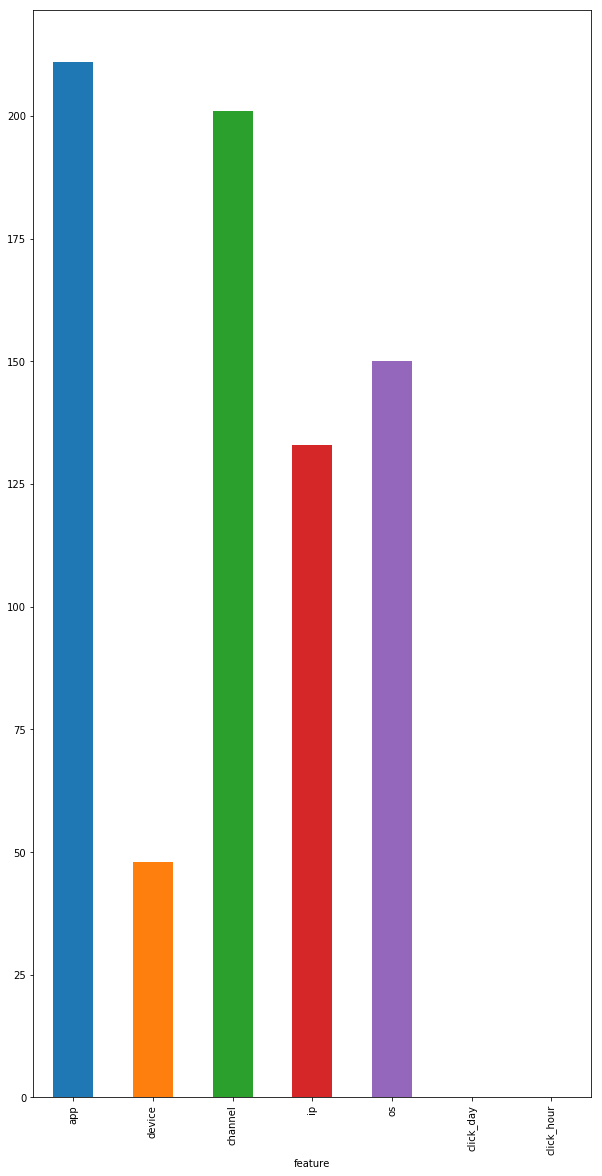

In [14]:
print("Feature gain/importance...")
gain = check_model.feature_importance('gain')
ft = pd.DataFrame({'feature':check_model.feature_name(), 
                   'split':check_model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft.head(25))

plt.figure()
ft[['feature','split']].head(25).plot(kind='bar', x='feature', y='split', legend=False, figsize=(10, 20))
#plt.gcf().savefig('feature_importance.png')
plt.show()

Based on the above numbers, we see that the ip, app, channel are the important features. Let's now draw new feature interaciton sbased on these for the final model. The final model uses train and test data. 

We see that the ip, app and channel are the featrues with maximum importance. Eventough ip stands on the top, we do not take ip
into consideration. Please note that I have dropped IP address, attributed time and click time columns after utilizing frequency counts from IP addresses and extracting weekday and hour from click time. IP addresses seems to be dynamic or possibly fake so I decided to not to use for model training directly.
This is with reference to: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/52374

Loading more data for modeling:

In [15]:
train_data = pd.read_csv(inputpath+'train.csv', nrows = 20000000,usecols = ['ip','app','device','os','channel','click_time','is_attributed'], dtype = define_dtypes)
test_data = pd.read_csv(inputpath+'test.csv',   usecols = ['ip','app','device','os','channel','click_time','click_id'], dtype = define_dtypes)

In [16]:
Combined_data = train_data.append(test_data)
del train_data
del test_data
gc.collect()
Combined_data.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os
0,3,379,NaN,2017-11-06 14:32:21,1,83230,0.0,13
1,3,379,NaN,2017-11-06 14:33:34,1,17357,0.0,19
2,3,379,NaN,2017-11-06 14:34:12,1,35810,0.0,13
3,14,478,NaN,2017-11-06 14:34:52,1,45745,0.0,13
4,3,379,NaN,2017-11-06 14:35:08,1,161007,0.0,13


Looking thoroughly at the click_time, we notice that the entire data is limited to only a few days and it does not make sense to include it in the analysis.
Instead we can only focus on the time of the clicks and get rid of the date.

In [17]:
Combined_data['hour'] = pd.to_datetime(Combined_data.click_time).dt.hour.astype('uint8')
Combined_data['day'] = pd.to_datetime(Combined_data.click_time).dt.day.astype('uint8')
Combined_data = Combined_data.drop(['click_time'], axis = 1)
gc.collect()

36

In [18]:
print('Grouping Combined data by ip-day-hour combination...')
gp = Combined_data[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})
Combined_data = Combined_data.merge(gp, on=['ip','day','hour'], how='left')
del gp
gc.collect()

Grouping Combined data by ip-day-hour combination...


62

In [19]:
print('Grouping Combined data by ip-app combination...')
gp =Combined_data[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
Combined_data = Combined_data.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

Grouping Combined data by ip-app combination...


98

In [20]:
print('Grouping Combined data by ip-app-os combination')
gp =  Combined_data[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
Combined_data = Combined_data.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()

Grouping Combined data by ip-app-os combination


114

In [21]:
#print("vars and data type: ")
Combined_data.info()
Combined_data['ip_tcount'] = Combined_data['ip_tcount'].astype('uint16')
Combined_data['ip_app_count'] = Combined_data['ip_app_count'].astype('uint16')
Combined_data['ip_app_os_count'] = Combined_data['ip_app_os_count'].astype('uint16')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38790469 entries, 0 to 38790468
Data columns (total 12 columns):
app                uint16
channel            uint16
click_id           float64
device             uint16
ip                 uint32
is_attributed      float64
os                 uint16
hour               uint8
day                uint8
ip_tcount          int64
ip_app_count       int64
ip_app_os_count    int64
dtypes: float64(2), int64(3), uint16(4), uint32(1), uint8(2)
memory usage: 2.2 GB


In [22]:
gc.collect()

17

In [24]:
test_df = Combined_data[Combined_data['click_id'].isnull() ==False] 
train_df, val_df = np.split(Combined_data[Combined_data['click_id'].isnull() ==True], [int(.95*(len(Combined_data[Combined_data['click_id'].isnull() ==True])))]) 

In [ ]:
#Checking the counts to make sure the train, test and validaiton splits are right
print(Combined_data.shape)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(38790469, 12)
(19000000, 12)
(18790469, 12)
(1000000, 12)


In [ ]:
#Fitting the  lgbm final model to train and validation datasets
output = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour', 'day', 'ip_app_os_count','ip_app_count','ip_tcount']
#train_df, val_df = np.split(train_data, [int(.95*(len(train_data)))]) #Splitting into train and validation datasets np.split(train_data, [int(.95*(len(train_data)))]) #Splitting into train and validation datasets
train_df, val_df = np.split(Combined_data[Combined_data['click_id'].isnull() ==True], [int(.95*(len(Combined_data[Combined_data['click_id'].isnull() ==True])))]) 
#train_lgb(predictors,output)
params = {
        'learning_rate': 0.15,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':99 # because training data is extremely unbalanced 
    }
check_model = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30
                        #verbose_eval=True, 
                        #num_boost_round=500 
                        #categorical_features=categorical
                        )

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.940374	valid's auc: 0.939935
[20]	train's auc: 0.954658	valid's auc: 0.95738
[30]	train's auc: 0.958582	valid's auc: 0.961482
[40]	train's auc: 0.962843	valid's auc: 0.963809
[50]	train's auc: 0.965054	valid's auc: 0.96572


In [48]:
Submission = pd.DataFrame()

#Submission['click_id'] = test_df['click_id'].astype('int')
Submission['is_attributed'] = check_model.predict(test_df[predictors])
#Submission.head()
Submission.to_csv('submission.csv',index=False)
#print("done...")